# NN  - This is a Multilayer Perceptron (MLP) example using Keras

    Copyright (C) 2020 Adrian Bevan, and 2023, 2024 Abbey Waldron
    Queen Mary University of London

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
----------------------

## Useful background on MNIST and data wrangling

MLP example using a Keras model. This is a simple example of a 2 layer MLP processing the MNIST data using the Adam optimiser.  The MNIST data is a set of 60,000 training and 10,000 test examples.  Each example is a hand written integer between 0 and 9, represented by a greyscale image with 28x28 pixels. This constitutes a 784 dimensional input feature space, where each image is a number between 0 and 255 (8 bit greyscale).  In order for an image to be processed efficiently by a neural network the pixel colour in the range $[0, 255]$ is mapped into the domain $[0, 1]$, following the usual [Efficient Backpropagation](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) data wrangling guidelines. For an MLP the 28x28 pixel image features (i.e. the pixels) are considered a linear set of 784 features that are input to the network.

For more information about the Adam optimiser please see the  paper by Kingma and Ba, [arXiv:1412.6980](https://arxiv.org/abs/1412.6980).

----------------------
## Load and pre-process the data

The MNIST data are directly accessible via keras as a dataset. So we first load the data. As noted above (and as you will have explored in the linear regression example), it is important to closely match the weights used in a network with the feature space domain that is being studied, so that the optimiser has less work to do in order to converge to the optimal solution.  In this case we achieve that by mapping the 8-bit greyscale color value $[0, 255]$ on the domain $[0, 1]$.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt

print("\033[92mLoading the MNIST data from keras\033[0m")
# Load the MNIST data via the tensorflow keras dataset:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("\tN(train) = ", len(x_train))
print("\tN(test) = ", len(x_test))


Loading the MNIST data from keras
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
	N(train) =  60000
	N(test) =  10000


---------------------
## Building the model 

**Training [Epochs, batches and validation data]** The number of training epochs specified is denoted by `Nepochs`.  1 epoch is required to run over all of the training data.  It is possible to run batches or mini-batches of data through the training; each batch requires the optimisation to be performed, and so when specifying the `BatchSize` the training will be performed by running the optimisation $N_{epochs}\times N_{batches}$ times.  In general this leads to faster optimisation of the model than optimising over the full training set each time.

The training data will be split into training and validation samples according to the value of the variable `ValidationSplit`. 

**Dropout:** Coadaptation is the ability for an optimisation algorithm to allow weights to be learned where changes in one node can be compensated by changes in another node that limit the increase in performance.  This issue can be a problem for deep networks in particular where the optimisation process can involve millions of hyperparameters.  A way to combat this issue is to randomly drop-out nodes in the network each iteration of the optimisation.  That way no single paring of nodes can learn to co-adapt to the evolution of hyperparameters through the optimisation.  Thankfully all the user has to do is to set a dropout value via the variable `DropoutValue`. 

**NOTE:** this value is the fraction of nodes dropped from the model.

**Loss:** The cross entropy loss function is used for this optimisation process.  The value of the loss function is converted into an output vector of 1's and 0's to be used for classification.

### Model configuration

The MLP consists of an input layer, two hidden layers, in this case one drop out layer and finally an output layer. These are as follows:
- **Inputs:** This model specifies an input shape of 28x28 that is flattened. The purpose of this is to ensure that there are 784 input features being fed into the hidden layers of the network.
- **Hidden Layers:** This network has two hidden layers, wich using a leaky ReLU (Rectified Linear Unit) activation function.  The parameter alpha defines the slope of the function for negative values, and for positive values the activation function is simply $f(x)=x$.
- **Dropout Layer:** Here the only dropout layer is the one from the second hidden layer of the network to the output.  You may wish to explore what happens if another dropout layer is added after the first hidden layer.
- **Output:** The output is a vector of 10 numbers. As the loss function is a cross entropy loss function the output in this case will be a one hot vector, i.e. a vector of 10 digits that are either 0 or 1.  The element corresponding to 1 being the optimal classificaiton of the example.



In [11]:
#
# Training configuration
#
ValidationSplit = 0.5
BatchSize       = 10 # be careful with this - if it is too big may crash.
Nepochs         = 10
DropoutValue    = 0.1

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),  # MNIST is 28x28 pixel images
  tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  tf.keras.layers.Dropout(DropoutValue),
  tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1))
])

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a multilayer perceptron on MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("2 layer MLP with configuration 784:128:128:10")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("ValidationSplit      = ", ValidationSplit)
print("BatchSize            = ", BatchSize)
print("Nepochs              = ", Nepochs, "\n")
print("N(train)             = ", len(x_train))
print("N(test)              = ", len(x_test))

# now specify the loss function - cross entropy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


# now we can train the model to make predictions.
#   Use the ADAM optimiser
#   Specify the metrics to report as accuracy
#   Specify the loss function (see above)
# the fit step specifies the number of training epochs
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
history  = model.fit(x_train, y_train, validation_split=ValidationSplit, batch_size=BatchSize, epochs=Nepochs
)




--------------------------------------------------------------------------------------------------------------
Will train a multilayer perceptron on MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
2 layer MLP with configuration 784:128:128:10
Dropout values       =  0.1
Leaky relu parameter =  0.1
ValidationSplit      =  0.5
BatchSize            =  10
Nepochs              =  10 

N(train)             =  60000
N(test)              =  10000
Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9001 - loss: 0.3433 - val_accuracy: 0.9391 - val_loss: 0.2064
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9568 - loss: 0.1434 - val_accuracy: 0.9507 - val_loss: 0.1751
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9704 - loss: 0.0967 - val_accuracy: 0.9610 - val_loss: 0.1427
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9790 -

Training history contains the following keys:
	 accuracy
	 loss
	 val_accuracy
	 val_loss

Display the evolution of the accuracy as a function of the training epoch

  N(Epochs)           =  10
  accuracy (train)     =  [0.9001333117485046, 0.956766664981842, 0.9704333543777466, 0.9789666533470154, 0.9814333319664001, 0.9838666915893555, 0.9874666929244995, 0.9869999885559082, 0.9889333248138428, 0.9908000230789185]
  accuracy (validate)  =  [0.9390666484832764, 0.9506999850273132, 0.9610000252723694, 0.9639999866485596, 0.9671333432197571, 0.9634666442871094, 0.9640666842460632, 0.9688666462898254, 0.9682666659355164, 0.9696666598320007]


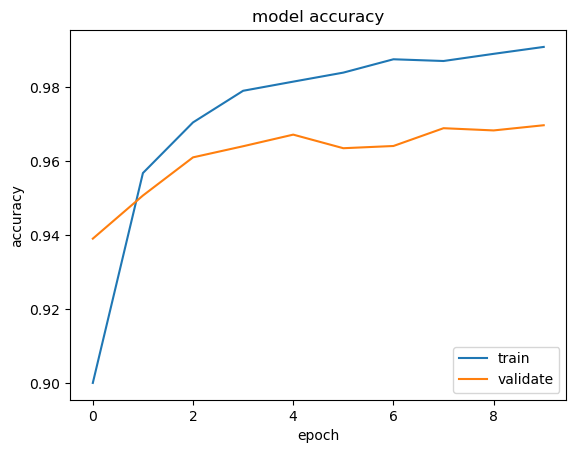


Display the evolution of the loss as a function of the training epoch

  N(Epochs)        =  10
  loss (train)     =  [0.34333309531211853, 0.1433609575033188, 0.096682608127594, 0.06922286748886108, 0.05662413686513901, 0.04694196954369545, 0.03813426196575165, 0.03959030285477638, 0.0337257906794548, 0.029337726533412933]
  loss (validate)  =  [0.20640850067138672, 0.1751205027103424, 0.1427486091852188, 0.13719415664672852, 0.13581907749176025, 0.15956825017929077, 0.1619751751422882, 0.15358369052410126, 0.15779827535152435, 0.16597600281238556]


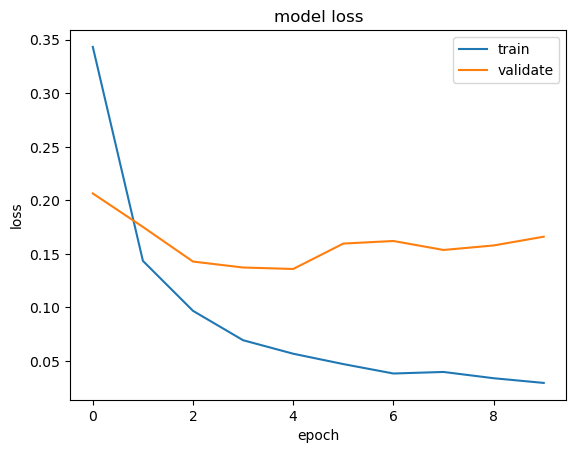


Performance summary (on test data):
313/313 - 0s - 790us/step - accuracy: 0.9715 - loss: 0.1524
	loss = 0.152
	accuracy = 0.971


In [12]:
# Print out the history keys expected are:
#    loss          The loss function evaluated at each epoch for the training set
#    accuracy      The accuracy evaluated at each epoch for the training set
#    val_loss      The loss evaluated at each epoch for the validation set
#    val_accuracy  The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

keys = history.history.keys()
print("\033[1mTraining history contains the following keys:\033[0m")
for key in keys:
    print ("\t", key)
    
print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m\n")
print("  N(Epochs)           = ", Nepochs)
#print("  accuracy (train)    = ", history.history['acc'])
#print("  accuracy (validate) = ", history.history['val_acc'])
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
print("  accuracy (train)     = ", history.history['accuracy'])
print("  accuracy (validate)  = ", history.history['val_accuracy'])
plt.plot(history.history['accuracy']) # 'accuracy'
plt.plot(history.history['val_accuracy']) # 'val_accuracy'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.show()
plt.clf()

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m\n")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
print("  loss (validate)  = ", history.history['val_loss'])

# summarize history for loss
plt.plot(history.history['loss']) # 'loss'
plt.plot(history.history['val_loss']) # 'val_loss'
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

# having finished training the model, use this to evaluate the performance on a sample of test data
print("\n\033[1mPerformance summary (on test data):\033[0m")
loss, acc = model.evaluate(x_test, y_test, verbose=2) # make sure to use the test data set!
print("\tloss = {:5.3f}\n\taccuracy = {:5.3f}".format(loss, acc))


------------
## Output

When training a model we are interested in studying the accuracy of prediction (in this case how often do we correctly classify an MNIST image according to its true label), and about the evolution of the loss function for both the test and train samples of examples.  If the test and train sample loss functions are signficantly different that points toward a problem... the model could be under or over trained.

This information is stored in the 'history' variable. 

----------------------
## Suggested exercises:

 - Plot some of the training images and their true labels
 - Explore the effect of DropOut, ValidationSplit, Nepochs, and BatchSize have on the training (try to find a model where the test and train loss function values are similar.
 - Explore how the neural network structure affects the training performance (e.g. add double or halve the number of nodes in the hidden layers, the current value is 128 for both)
 - Explore the effect of adding a second dropout layer into the network after the first hidden layer.
 - What is the best performance you can get on this dataset?
 - Plot some images where the classification has failed.  Are they hard to figure out by eye?

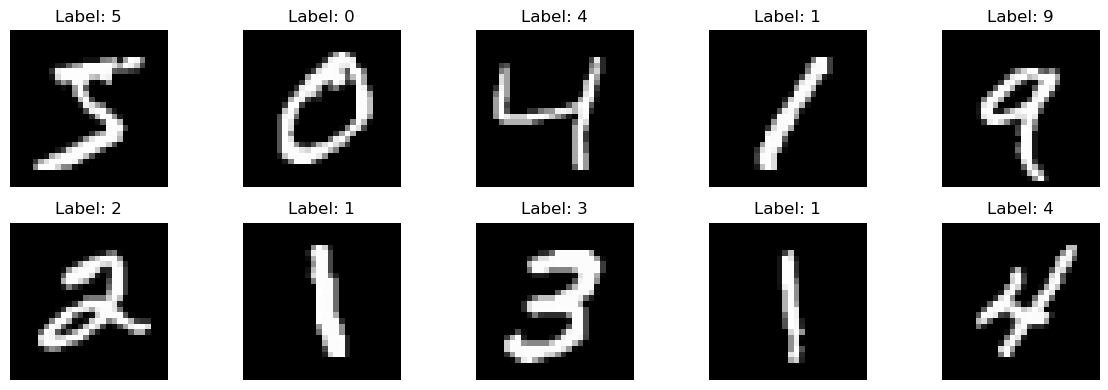

In [7]:
import numpy as np

# Number of images to show
n_images = 10

plt.figure(figsize=(12, 4))

for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()